# Introduction

In this homework you will be given a chance to explore the properties of word embedding using a pre-trained embedding. Then you will build and train your own embedding using the skip-gram method.

## Files
- `hw03.ipynb`: Notebook file with starter code
- `plot_summaries_tokenized.txt`: training data for skipgram
- `glove_6B_100d_top100k.csv`: pretrained glove embedding

The training data and glove embedding 


## Reading material

1. [Learning representations by back-propagating errors](https://www.nature.com/articles/323533a0)

Recent Turing Reward winner Geoffrey Hinton and coworkers first introduced the concept of words embedding in their 1986 Nature paper.

2. [word2vec](https://code.google.com/archive/p/word2vec/)

Google's word2vec project built on skip-gram and google news data.

3. [Efficient Estimation of Word Representations in
Vector Space](https://arxiv.org/pdf/1301.3781.pdf)

   [Distributed Representations of Words and Phrases
and their Compositionality](https://arxiv.org/pdf/1310.4546.pdf)

Tomas Mikolov from Google published these two papers in 2013 proposing the skip-gram approach for word embedding which has become one of the most popular word embedding.

4. [On word embeddings](http://ruder.io/word-embeddings-1/index.html)

An online blog by DeepMind engineer Sebastian Ruder explaining skip-gram. I found it easier to understand than the original papers.

## Deliverables:

- pdf / html version of your final notebook
- Discuss the questions in Section 3 (Play with pretrained)
- If you have done any work to improve the model and model training, explain it.

<h1><center> HW3 Write Up </center> </h1>

<h2>Find nearest words</h2>
The closest word to '8' are '9' and '7' which is very interesting.

The closest word to google are also technology companies.
<h2>Find nearest words with vector</h2>
glove['china']+glove['capital']
'beijing' is the closest output!

glove['beijing']-glove['china']+glove['italy']
'rome' is the closest output!
It means this embedding is able to reflect some deep connection/semantics of the words.

<h2>skip-gram</h2>
I tried to use more layers and regulazations, it tures out the losses for the skip-gram dummy classification problem is not stably going down and keep flat. It flucutate between 0.3 and 0.4, and the lowest losses is 0.29. Increasing the negative samples or enlarge the window size might make it better.

## =========================Coding starts here ==================

# Required pacakges

In [3]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn, keras
import numpy as np
import os, sys

# add utils folder to path
p = os.path.dirname(os.getcwd())
if p not in sys.path:
    sys.path = [p] + sys.path

from utils.hw3 import load_data
from utils.general import show_keras_model

# Play with pretrained embedding

Before we start training our own words embedding, let's play with pretrained embeddings, so you know what you can expect from your own models. Here we use a very popular embedding called [GloVe](https://nlp.stanford.edu/projects/glove/) developed by standford university. The method used to produce this embedding is based on the factorization of word-word similarity matrix. Worth to notice, thi method is quite different to the skip-gram method we are going to implement later.

First let's load the embedding as a Pandas DataFrame.

In [4]:
glove = pd.read_csv("glove_6B_100d_top100k.csv"); glove.head()

,the,",",.,of,to,and,in,a,"""",'s,...,antz,monnaie,copyist,toonami,bagration,divo,convulsive,unviable,madhava,autocephalous
0,-0.038194,-0.10767,-0.33979,-0.15290,-0.189700,-0.071953,0.085703,-0.270860,-0.30457,0.58854,...,0.175470,-0.032896,0.37886,0.339320,-0.52125,0.20375,0.42829,-0.560580,-0.26374,0.457840
1,-0.244870,0.11053,0.20941,-0.24279,0.050024,0.231270,-0.222010,0.044006,-0.23645,-0.20250,...,-0.559680,-0.721960,-0.24468,-0.266210,-1.09030,-0.07108,0.29863,-0.486880,0.20904,0.154020
2,0.728120,0.59812,0.46348,0.89837,0.190840,0.023731,0.165690,-0.020260,0.17576,0.73479,...,0.480470,-0.129030,0.45714,-0.224130,-0.66645,-0.13259,-0.15156,-0.314340,-1.12440,0.321590
3,-0.399610,-0.54361,-0.64792,0.16996,-0.049184,-0.506380,0.133730,-0.173950,-0.72854,-0.68338,...,0.287520,1.169300,0.17411,-1.158300,0.23457,0.15806,0.21284,-0.174410,0.25690,0.807420
4,0.083172,0.67396,-0.38377,0.53516,-0.089737,0.339230,0.382390,0.644400,-0.28343,-0.19675,...,-0.021609,0.335410,0.49281,-0.083679,0.36971,-0.48602,-0.13771,0.041936,-0.71330,-0.074811


## Find nearest words
One of the many motivations that people are interested in words embedding is that it reveals similarities between words. Let's first check how this works with GloVe.

In [5]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

def find_nearest(embedding, word=None, n=5, distance=euclidean_distances):
    """
    For given embedding matrix and a given word, find the n nearest words in the embedding space
    
    input:
        embedding: DataFrame, look at `glove` 
        word: string, must be in the index of embedding dataframe
        n: int, number of nearest words
        distance: fucntion, it should at least support the euclidean_distances and cosine_distances
        
    return:
        A series with word as index, distance as value, sorted from lower to high
    """

    if word not in embedding:
        print('word not in pre-trained model')
        return
    targetvec = embedding[word]
    d = distance(embedding.T,[targetvec])
    d = {embedding.columns[index]:value for (index, value) in enumerate(list(d))}
    import heapq
    k_keys_sorted = heapq.nsmallest(n+1, d,key=d.get)
    return pd.Series({k:d[k][0] for k in k_keys_sorted[1:]})

In [6]:
print("Using euclidean_distances, the closest words to frog are:")
print(find_nearest(glove, 'lion'))
print("Using cosine_distances, the closest words to frog are:")
print(find_nearest(glove, 'lion', distance=cosine_distances))

Using euclidean_distances, the closest words to frog are:
dragon      4.210776
elephant    4.273111
wolf        4.667664
beast       4.737944
cat         4.739263
dtype: float64
Using cosine_distances, the closest words to frog are:
dragon      0.301670
elephant    0.329856
leopard     0.386800
bear        0.386803
cat         0.404449
dtype: float64


In [8]:
print(find_nearest(glove, '8'))

print(find_nearest(glove, 'google', distance=cosine_distances))

9    0.943478
7    0.943649
6    1.037347
5    1.111455
4    1.339804
dtype: float64
yahoo        0.136264
microsoft    0.189590
web          0.237019
aol          0.242831
facebook     0.248342
dtype: float64


What have you observed? Does the result make sense to you? Play with some other words, and see if you can find something interesting. Try countries and numebrs :). 

## Find nearest words with vector
Remember that at the beginning of the course we advertised the ability of word embedding being able to find relative relationship between words, such as king - male + female = queen. Let's test this with the embedding we have. But before that we need a method that's similar to find_nearest, but instead of taking a word, it takes an embedding vector as input.

In [9]:
def find_nearest_with_vector(embedding, vector=None, n=5, distance=euclidean_distances):
    """
    For given embedding matrix and a given vector, find the n nearest words in the embedding space
    
    input:
        embedding: DataFrame, look at `glove` 
        vector: Series, looks like a coloumn vector of the embedding dataframe
        n: int, number of nearest words
        distance: fucntion, it should at least support the euclidean_distances and cosine_distances
        
    return:
        A series with word as index, distance as value, sorted from lower to high
    """
    
    d = distance(embedding.T,[vector])
    d = {embedding.columns[index]:value for (index, value) in enumerate(list(d))}
    import heapq
    k_keys_sorted = heapq.nsmallest(n+1, d,key=d.get)
    return pd.Series({k:d[k][0] for k in k_keys_sorted[1:]})

In [10]:
find_nearest_with_vector(glove, glove['king']-glove['male']+glove['female'])

queen      4.340831
prince     4.542057
monarch    4.704783
brother    4.717307
george     4.840019
dtype: float64

In [55]:
print(find_nearest_with_vector(glove, glove['china']+glove['capital']))
print(find_nearest_with_vector(glove, glove['beijing']-glove['china']+glove['italy']))

capital       6.866541
beijing       7.820086
chinese       8.027392
taiwan        8.451052
government    8.454450
dtype: float64
rome       4.265470
turin      4.500863
milan      4.876893
italian    4.959218
naples     5.059326
dtype: float64


What did you see? Can you explore some other interesting relations? Like countries vs cities, etc.

## Word clustering

Another feature of the word embedding is that it can cluster similar word in to the same cluster while keep semantic relationship with other clusters. Try the following dimention reduction code:

In [12]:
from sklearn.decomposition import PCA

def plot_2D(X, labels):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = 0.1 + 0.8 * (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 8))
    for x, lab in zip(X, labels):
        plt.text(x[0], x[1], str(lab), fontdict={'size': 14})
        
def plot_words_embedding(embedding, words):
    X = PCA(n_components=2).fit_transform(embedding[words].transpose())
    plot_2D(X, words)

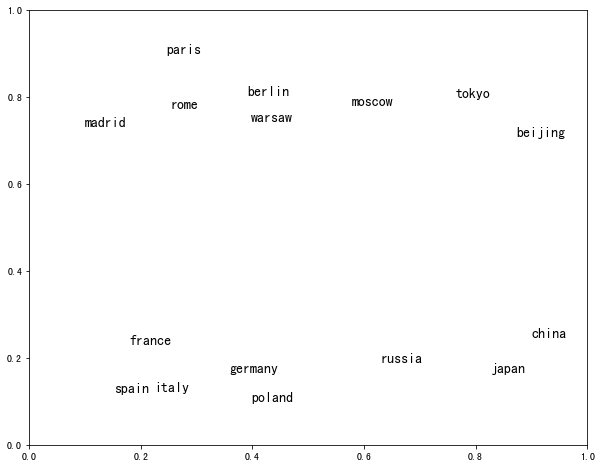

In [13]:
words = ['china', 'beijing', 'russia', 'moscow', 'poland', 'warsaw', 'japan', 'tokyo',
        'france', 'paris', 'germany', 'berlin', 'italy', 'rome', 'spain', 'madrid']

plot_words_embedding(glove, words)

Have you spot something interesting? Try with some other words set and see what you can find.

# Skip-gram

## Load the training data

In [14]:
#from tools import load_data, show_model

text = load_data("plot_summaries_tokenized.txt")

print("Number of summarys: ", len(text))
print("Number of words:", len([w for s in text for w in s]))
print("Vocabulary size:", len({w for s in text for w in s}))

Number of summarys:  42306
Number of words: 13065221
Vocabulary size: 190786


There are about 200K unique words in this corpus. To make it more computational feasible, let's reduce the size of the vocabulary:

## Encode the text

In [15]:
MIN_COUNT = 20
def create_encoder(text, min_count=20):
    """
    - Create a encoder which is a dictionary like {word: index}
    - To reduce the total number of vocabularies, you can remove 
    the words that appear for less than min_count times in the entire
    corpus
    - Enfore {'_unknown_': 0}
    
    input:
        text: list of token list, e.g. [['i', 'am', 'fine'], ['another', 'summary'], ...]
    returns:
        tokenmap:  encoder dictionary
        tokenmap_reverse: reversed tokenmap {index: word} to faciliate inverse lookup
    """
    tokencount = {}
    tokenmap = {}
    tokenmap_reverse = {}
    for tokens in text:
        for token in tokens:
            tokencount[token] = tokencount.get(token, 0) + 1
    index = 0
    for tokens in text:
        for token in tokens:
            if tokencount[token] >= min_count:
                if token not in tokenmap:
                    tokenmap[token] = index
                    tokenmap_reverse[index] = token
                    index += 1
    return (tokenmap, tokenmap_reverse)

In [16]:
tokenmap, tokenmap_reverse = create_encoder(text, MIN_COUNT)
VOCAB_SIZE = len(tokenmap)
print("the reduced vocabulary size is:", VOCAB_SIZE)

the reduced vocabulary size is: 26343


In [17]:
# Encoder the text using the encoder you just created
def encode(text, tokenmap, default=0):
    return [[tokenmap.get(t, default) for t in s] for s in text]

In [18]:
text_encoded = encode(text, tokenmap)

## Construct training context pairs

To generate training data, we need to find word-context pairs from the encoded text, 
we also want to generate some negative sample, so the input and output may look like:

for input corpus: [[2, 3, 1, 2]] 

returns: [[word, context, label]]

[[2, 3, 1], [2, 1, 1], [2, 2, 1], [3, 1, 1], ...., [4, 2, 0], [4, 3, 0], ...]

Notice that in practice the sequence should be shuffled.

In [19]:
from keras.preprocessing.sequence import skipgrams

def training_data_generator(text_encoded, window_size=4, negative_samples=1.0, batch_docs=50):
    """
    For given encoded text, return 3 np.array:
    words, contexts, labels
    Do not pair the w and its context cross different documents.
    
    input: 
        text_encoded: list of list of int, each list of int is the numerical encoding of the doc
        window_size: int, define the context
        negative_samples: float, how much negative sampling you need, normally 1.0
        batch_docs: int, number of docs for which it generates one return
        
    return:
        words: list of int, the numerical encoding of the central words
        contexts: list of int, the numerical encoding of the context words
        labels: list of int, 1 or 0
        
    hint: 
    1. You can use skipgrams method from keras
    2. For training purpose, words and contexts needs to be 2D array, with shape (N, 1), 
       but labels is 1D array, with shape (N, )
    3. The output can be very big, you SHOULD using generator
    """
    for index, text in enumerate(text_encoded[::batch_docs]):
        labels = []
        words = []
        contexts = []
        for t in text_encoded[index:index+batch_docs]:
            sg = skipgrams(sequence=t, vocabulary_size=VOCAB_SIZE, window_size=window_size, negative_samples=negative_samples, shuffle=True, categorical=False, sampling_table=None, seed=None)
            labels.extend(sg[1])
            words.extend([w[0] for w in sg[0]])
            contexts.extend([w[1] for w in sg[0]])
        N = len(labels)
        yield np.array(words).reshape(N,1), np.array(contexts).reshape(N,1), np.array(labels)
        

## Construct Learning Model

Now we need to create a network that looks like this:
<img src="skip-gram-NN.png" width="480">

In [20]:
from keras.layers import Input, Activation, Reshape, dot, Embedding, Permute
from keras.models import Model

# Define two input layers

input_words = Input(shape=(1,))
input_contexts = Input(shape=(1,))

# Embedding for the text
embed = Embedding(VOCAB_SIZE, 100, input_length=1)

embed1 = embed(input_words)
embed1 = Reshape((100,))(embed1)

embed2 = embed(input_contexts)
embed2 = Reshape((100,))(embed2)

# Concatenate the convolutional features and the vector input
dot_product = dot([embed1, embed2], axes=1, normalize=False)
output = Activation('sigmoid')(dot_product)

# define a model with a list of two inputs
model = Model(inputs=[input_words, input_contexts], outputs=output)
print(model.summary())

W0318 16:06:57.453799 4315479488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0318 16:06:57.489341 4315479488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0318 16:06:57.513157 4315479488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       2634300     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100)          0           embedding_1[0][0]                
__________

## Train your model 

The following is a simple version of training on batch code. You do not need to use
opochs more than 10 since it will soon start shaking around the minimum. If you want 
to further improve your training, consider gradually increase the batch size or reduce 
the learning rate, then you can try for more than 10 epochs.

In [21]:
import matplotlib.pyplot as plt
model.compile(loss="binary_crossentropy", optimizer="rmsprop")

epochs = 10
ntot = 0

for epoch in range(epochs):
    print("Epoch %d ======" % epoch)
    for words, contexts, labels in training_data_generator(text_encoded, window_size=4,batch_docs=100):
        loss = model.train_on_batch(x=[words, contexts], y=labels)
        ntot += len(words)
        print("Total trained pairs (M): %10.2f ; \t loss: %.4f" % (ntot/1e6, loss))


W0318 16:07:15.124368 4315479488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0318 16:07:15.143607 4315479488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0318 16:07:15.151264 4315479488 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 0 ======


W0318 16:07:19.196613 4315479488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Total trained pairs (M):       0.52 ; 	 loss: 0.6930
Total trained pairs (M):       1.04 ; 	 loss: 0.6925
Total trained pairs (M):       1.56 ; 	 loss: 0.6919
Total trained pairs (M):       2.09 ; 	 loss: 0.6913
Total trained pairs (M):       2.60 ; 	 loss: 0.6905
Total trained pairs (M):       3.11 ; 	 loss: 0.6896
Total trained pairs (M):       3.62 ; 	 loss: 0.6885
Total trained pairs (M):       4.12 ; 	 loss: 0.6874
Total trained pairs (M):       4.62 ; 	 loss: 0.6861
Total trained pairs (M):       5.12 ; 	 loss: 0.6847
Total trained pairs (M):       5.62 ; 	 loss: 0.6832
Total trained pairs (M):       6.12 ; 	 loss: 0.6816
Total trained pairs (M):       6.62 ; 	 loss: 0.6798
Total trained pairs (M):       7.12 ; 	 loss: 0.6780
Total trained pairs (M):       7.62 ; 	 loss: 0.6760
Total trained pairs (M):       8.10 ; 	 loss: 0.6741
Total trained pairs (M):       8.58 ; 	 loss: 0.6720
Total trained pairs (M):       9.06 ; 	 loss: 0.6698
Total trained pairs (M):       9.55 ; 	 loss: 

Total trained pairs (M):      79.34 ; 	 loss: 0.4058
Total trained pairs (M):      79.84 ; 	 loss: 0.4087
Total trained pairs (M):      80.32 ; 	 loss: 0.4085
Total trained pairs (M):      80.81 ; 	 loss: 0.4072
Total trained pairs (M):      81.30 ; 	 loss: 0.4048
Total trained pairs (M):      81.79 ; 	 loss: 0.4042
Total trained pairs (M):      82.27 ; 	 loss: 0.4019
Total trained pairs (M):      82.77 ; 	 loss: 0.4058
Total trained pairs (M):      83.28 ; 	 loss: 0.4081
Total trained pairs (M):      83.79 ; 	 loss: 0.4088
Total trained pairs (M):      84.31 ; 	 loss: 0.4069
Total trained pairs (M):      84.83 ; 	 loss: 0.4074
Total trained pairs (M):      85.35 ; 	 loss: 0.4075
Total trained pairs (M):      85.86 ; 	 loss: 0.4065
Total trained pairs (M):      86.38 ; 	 loss: 0.4066
Total trained pairs (M):      86.89 ; 	 loss: 0.4035
Total trained pairs (M):      87.40 ; 	 loss: 0.4073
Total trained pairs (M):      87.91 ; 	 loss: 0.4053
Total trained pairs (M):      88.41 ; 	 loss: 

Total trained pairs (M):     151.69 ; 	 loss: 0.4563
Total trained pairs (M):     152.15 ; 	 loss: 0.4558
Total trained pairs (M):     152.61 ; 	 loss: 0.4559
Total trained pairs (M):     153.08 ; 	 loss: 0.4573
Total trained pairs (M):     153.55 ; 	 loss: 0.4591
Total trained pairs (M):     154.02 ; 	 loss: 0.4589
Total trained pairs (M):     154.50 ; 	 loss: 0.4578
Total trained pairs (M):     154.97 ; 	 loss: 0.4582
Total trained pairs (M):     155.44 ; 	 loss: 0.4560
Total trained pairs (M):     155.92 ; 	 loss: 0.4556
Total trained pairs (M):     156.39 ; 	 loss: 0.4558
Total trained pairs (M):     156.87 ; 	 loss: 0.4566
Total trained pairs (M):     157.35 ; 	 loss: 0.4534
Total trained pairs (M):     157.82 ; 	 loss: 0.4514
Total trained pairs (M):     158.30 ; 	 loss: 0.4552
Total trained pairs (M):     158.77 ; 	 loss: 0.4550
Total trained pairs (M):     159.25 ; 	 loss: 0.4527
Total trained pairs (M):     159.72 ; 	 loss: 0.4550
Total trained pairs (M):     160.19 ; 	 loss: 

Total trained pairs (M):     222.68 ; 	 loss: 0.4402
Total trained pairs (M):     223.16 ; 	 loss: 0.4395
Total trained pairs (M):     223.64 ; 	 loss: 0.4371
Total trained pairs (M):     224.12 ; 	 loss: 0.4356
Total trained pairs (M):     224.61 ; 	 loss: 0.4351
Total trained pairs (M):     225.09 ; 	 loss: 0.4332
Total trained pairs (M):     225.57 ; 	 loss: 0.4325
Total trained pairs (M):     226.05 ; 	 loss: 0.4309
Total trained pairs (M):     226.53 ; 	 loss: 0.4278
Total trained pairs (M):     227.02 ; 	 loss: 0.4282
Total trained pairs (M):     227.50 ; 	 loss: 0.4275
Total trained pairs (M):     227.99 ; 	 loss: 0.4247
Total trained pairs (M):     228.48 ; 	 loss: 0.4246
Total trained pairs (M):     228.97 ; 	 loss: 0.4204
Total trained pairs (M):     229.46 ; 	 loss: 0.4202
Total trained pairs (M):     229.98 ; 	 loss: 0.4226
Total trained pairs (M):     230.51 ; 	 loss: 0.4242
Total trained pairs (M):     231.04 ; 	 loss: 0.4237
Total trained pairs (M):     231.56 ; 	 loss: 

Total trained pairs (M):     300.74 ; 	 loss: 0.4347
Total trained pairs (M):     301.16 ; 	 loss: 0.4351
Total trained pairs (M):     301.60 ; 	 loss: 0.4424
Total trained pairs (M):     302.06 ; 	 loss: 0.4478
Total trained pairs (M):     302.52 ; 	 loss: 0.4499
Total trained pairs (M):     302.96 ; 	 loss: 0.4482
Total trained pairs (M):     303.41 ; 	 loss: 0.4465
Total trained pairs (M):     303.86 ; 	 loss: 0.4458
Total trained pairs (M):     304.30 ; 	 loss: 0.4446
Total trained pairs (M):     304.75 ; 	 loss: 0.4450
Total trained pairs (M):     305.19 ; 	 loss: 0.4436
Total trained pairs (M):     305.64 ; 	 loss: 0.4435
Total trained pairs (M):     306.08 ; 	 loss: 0.4416
Total trained pairs (M):     306.53 ; 	 loss: 0.4429
Total trained pairs (M):     306.98 ; 	 loss: 0.4430
Total trained pairs (M):     307.43 ; 	 loss: 0.4423
Total trained pairs (M):     307.88 ; 	 loss: 0.4412
Total trained pairs (M):     308.33 ; 	 loss: 0.4436
Total trained pairs (M):     308.78 ; 	 loss: 

Total trained pairs (M):     373.14 ; 	 loss: 0.4400
Total trained pairs (M):     373.60 ; 	 loss: 0.4384
Total trained pairs (M):     374.05 ; 	 loss: 0.4388
Total trained pairs (M):     374.50 ; 	 loss: 0.4356
Total trained pairs (M):     374.95 ; 	 loss: 0.4343
Total trained pairs (M):     375.41 ; 	 loss: 0.4328
Total trained pairs (M):     375.87 ; 	 loss: 0.4312
Total trained pairs (M):     376.33 ; 	 loss: 0.4289
Total trained pairs (M):     376.78 ; 	 loss: 0.4299
Total trained pairs (M):     377.23 ; 	 loss: 0.4295
Total trained pairs (M):     377.69 ; 	 loss: 0.4313
Total trained pairs (M):     378.15 ; 	 loss: 0.4303
Total trained pairs (M):     378.61 ; 	 loss: 0.4295
Total trained pairs (M):     379.07 ; 	 loss: 0.4281
Total trained pairs (M):     379.52 ; 	 loss: 0.4317
Total trained pairs (M):     379.97 ; 	 loss: 0.4336
Total trained pairs (M):     380.41 ; 	 loss: 0.4304
Total trained pairs (M):     380.86 ; 	 loss: 0.4342
Total trained pairs (M):     381.30 ; 	 loss: 

Total trained pairs (M):     445.18 ; 	 loss: 0.4207
Total trained pairs (M):     445.70 ; 	 loss: 0.4201
Total trained pairs (M):     446.22 ; 	 loss: 0.4185
Total trained pairs (M):     446.73 ; 	 loss: 0.4174
Total trained pairs (M):     447.26 ; 	 loss: 0.4226
Total trained pairs (M):     447.80 ; 	 loss: 0.4234
Total trained pairs (M):     448.34 ; 	 loss: 0.4220
Total trained pairs (M):     448.87 ; 	 loss: 0.4216
Total trained pairs (M):     449.42 ; 	 loss: 0.4203
Total trained pairs (M):     449.97 ; 	 loss: 0.4216
Total trained pairs (M):     450.53 ; 	 loss: 0.4197
Total trained pairs (M):     451.09 ; 	 loss: 0.4188
Total trained pairs (M):     451.63 ; 	 loss: 0.4195
Total trained pairs (M):     452.20 ; 	 loss: 0.4185
Total trained pairs (M):     452.75 ; 	 loss: 0.4182
Total trained pairs (M):     453.31 ; 	 loss: 0.4160
Total trained pairs (M):     453.86 ; 	 loss: 0.4177
Total trained pairs (M):     454.38 ; 	 loss: 0.4174
Total trained pairs (M):     454.90 ; 	 loss: 

Total trained pairs (M):     521.19 ; 	 loss: 0.4146
Total trained pairs (M):     521.64 ; 	 loss: 0.4116
Total trained pairs (M):     522.10 ; 	 loss: 0.4119
Total trained pairs (M):     522.55 ; 	 loss: 0.4119
Total trained pairs (M):     523.01 ; 	 loss: 0.4105
Total trained pairs (M):     523.44 ; 	 loss: 0.4145
Total trained pairs (M):     523.88 ; 	 loss: 0.4174
Total trained pairs (M):     524.31 ; 	 loss: 0.4155
Total trained pairs (M):     524.75 ; 	 loss: 0.4173
Total trained pairs (M):     525.18 ; 	 loss: 0.4151
Total trained pairs (M):     525.62 ; 	 loss: 0.4152
Total trained pairs (M):     526.06 ; 	 loss: 0.4134
Total trained pairs (M):     526.54 ; 	 loss: 0.4274
Total trained pairs (M):     527.01 ; 	 loss: 0.4264
Total trained pairs (M):     527.48 ; 	 loss: 0.4241
Total trained pairs (M):     527.95 ; 	 loss: 0.4251
Total trained pairs (M):     528.43 ; 	 loss: 0.4254
Total trained pairs (M):     528.91 ; 	 loss: 0.4248
Total trained pairs (M):     529.39 ; 	 loss: 

Total trained pairs (M):     592.91 ; 	 loss: 0.4227
Total trained pairs (M):     593.33 ; 	 loss: 0.4215
Total trained pairs (M):     593.74 ; 	 loss: 0.4192
Total trained pairs (M):     594.17 ; 	 loss: 0.4237
Total trained pairs (M):     594.60 ; 	 loss: 0.4247
Total trained pairs (M):     595.02 ; 	 loss: 0.4268
Total trained pairs (M):     595.44 ; 	 loss: 0.4248
Total trained pairs (M):     595.87 ; 	 loss: 0.4239
Total trained pairs (M):     596.30 ; 	 loss: 0.4241
Total trained pairs (M):     596.72 ; 	 loss: 0.4230
Total trained pairs (M):     597.17 ; 	 loss: 0.4260
Total trained pairs (M):     597.62 ; 	 loss: 0.4289
Total trained pairs (M):     598.07 ; 	 loss: 0.4273
Total trained pairs (M):     598.52 ; 	 loss: 0.4257
Total trained pairs (M):     598.96 ; 	 loss: 0.4263
Total trained pairs (M):     599.40 ; 	 loss: 0.4253
Total trained pairs (M):     599.85 ; 	 loss: 0.4354
Total trained pairs (M):     600.30 ; 	 loss: 0.4397
Total trained pairs (M):     600.75 ; 	 loss: 

Total trained pairs (M):     668.92 ; 	 loss: 0.3846
Total trained pairs (M):     669.46 ; 	 loss: 0.3833
Total trained pairs (M):     669.98 ; 	 loss: 0.3871
Total trained pairs (M):     670.50 ; 	 loss: 0.3865
Total trained pairs (M):     671.03 ; 	 loss: 0.3829
Total trained pairs (M):     671.54 ; 	 loss: 0.3830
Total trained pairs (M):     672.07 ; 	 loss: 0.3852
Total trained pairs (M):     672.60 ; 	 loss: 0.3846
Total trained pairs (M):     673.11 ; 	 loss: 0.3835
Total trained pairs (M):     673.63 ; 	 loss: 0.3826
Total trained pairs (M):     674.15 ; 	 loss: 0.3818
Total trained pairs (M):     674.66 ; 	 loss: 0.3811
Total trained pairs (M):     675.17 ; 	 loss: 0.3797
Total trained pairs (M):     675.69 ; 	 loss: 0.3784
Total trained pairs (M):     676.21 ; 	 loss: 0.3808
Total trained pairs (M):     676.74 ; 	 loss: 0.3785
Total trained pairs (M):     677.27 ; 	 loss: 0.3769
Total trained pairs (M):     677.80 ; 	 loss: 0.3801
Total trained pairs (M):     678.31 ; 	 loss: 

Total trained pairs (M):     742.59 ; 	 loss: 0.3849
Total trained pairs (M):     743.10 ; 	 loss: 0.3862
Total trained pairs (M):     743.61 ; 	 loss: 0.3851
Total trained pairs (M):     744.12 ; 	 loss: 0.3830
Total trained pairs (M):     744.63 ; 	 loss: 0.3811
Total trained pairs (M):     745.15 ; 	 loss: 0.3811
Total trained pairs (M):     745.67 ; 	 loss: 0.3785
Total trained pairs (M):     746.18 ; 	 loss: 0.3772
Total trained pairs (M):     746.70 ; 	 loss: 0.3758
Total trained pairs (M):     747.21 ; 	 loss: 0.3778
Total trained pairs (M):     747.71 ; 	 loss: 0.3752
Total trained pairs (M):     748.23 ; 	 loss: 0.3771
Total trained pairs (M):     748.73 ; 	 loss: 0.3776
Total trained pairs (M):     749.23 ; 	 loss: 0.3767
Total trained pairs (M):     749.73 ; 	 loss: 0.3767
Total trained pairs (M):     750.22 ; 	 loss: 0.3750
Total trained pairs (M):     750.72 ; 	 loss: 0.3748
Total trained pairs (M):     751.21 ; 	 loss: 0.3742
Total trained pairs (M):     751.69 ; 	 loss: 

Total trained pairs (M):     813.69 ; 	 loss: 0.5109
Total trained pairs (M):     814.19 ; 	 loss: 0.5075
Total trained pairs (M):     814.69 ; 	 loss: 0.5041
Total trained pairs (M):     815.19 ; 	 loss: 0.5005
Total trained pairs (M):     815.69 ; 	 loss: 0.4979
Total trained pairs (M):     816.19 ; 	 loss: 0.4923
Total trained pairs (M):     816.67 ; 	 loss: 0.4906
Total trained pairs (M):     817.15 ; 	 loss: 0.4885
Total trained pairs (M):     817.63 ; 	 loss: 0.4846
Total trained pairs (M):     818.11 ; 	 loss: 0.4821
Total trained pairs (M):     818.59 ; 	 loss: 0.4780
Total trained pairs (M):     819.07 ; 	 loss: 0.4733
Total trained pairs (M):     819.55 ; 	 loss: 0.4714
Total trained pairs (M):     820.02 ; 	 loss: 0.4689
Total trained pairs (M):     820.50 ; 	 loss: 0.4674
Total trained pairs (M):     820.98 ; 	 loss: 0.4641
Total trained pairs (M):     821.47 ; 	 loss: 0.4598
Total trained pairs (M):     821.95 ; 	 loss: 0.4557
Total trained pairs (M):     822.41 ; 	 loss: 

Total trained pairs (M):     892.36 ; 	 loss: 0.3468
Total trained pairs (M):     892.88 ; 	 loss: 0.3447
Total trained pairs (M):     893.40 ; 	 loss: 0.3470
Total trained pairs (M):     893.91 ; 	 loss: 0.3461
Total trained pairs (M):     894.43 ; 	 loss: 0.3449
Total trained pairs (M):     894.95 ; 	 loss: 0.3444
Total trained pairs (M):     895.46 ; 	 loss: 0.3431
Total trained pairs (M):     895.97 ; 	 loss: 0.3445
Total trained pairs (M):     896.47 ; 	 loss: 0.3424
Total trained pairs (M):     896.98 ; 	 loss: 0.3430
Total trained pairs (M):     897.48 ; 	 loss: 0.3404
Total trained pairs (M):     897.97 ; 	 loss: 0.3420
Total trained pairs (M):     898.45 ; 	 loss: 0.3412
Total trained pairs (M):     898.93 ; 	 loss: 0.3395
Total trained pairs (M):     899.41 ; 	 loss: 0.3386
Total trained pairs (M):     899.87 ; 	 loss: 0.3414
Total trained pairs (M):     900.33 ; 	 loss: 0.3406
Total trained pairs (M):     900.78 ; 	 loss: 0.3392
Total trained pairs (M):     901.22 ; 	 loss: 

Total trained pairs (M):     964.48 ; 	 loss: 0.3536
Total trained pairs (M):     964.96 ; 	 loss: 0.3528
Total trained pairs (M):     965.44 ; 	 loss: 0.3532
Total trained pairs (M):     965.91 ; 	 loss: 0.3523
Total trained pairs (M):     966.39 ; 	 loss: 0.3493
Total trained pairs (M):     966.87 ; 	 loss: 0.3523
Total trained pairs (M):     967.34 ; 	 loss: 0.3523
Total trained pairs (M):     967.81 ; 	 loss: 0.3517
Total trained pairs (M):     968.29 ; 	 loss: 0.3511
Total trained pairs (M):     968.76 ; 	 loss: 0.3497
Total trained pairs (M):     969.23 ; 	 loss: 0.3491
Total trained pairs (M):     969.72 ; 	 loss: 0.3512
Total trained pairs (M):     970.19 ; 	 loss: 0.3516
Total trained pairs (M):     970.67 ; 	 loss: 0.3510
Total trained pairs (M):     971.13 ; 	 loss: 0.3504
Total trained pairs (M):     971.59 ; 	 loss: 0.3503
Total trained pairs (M):     972.06 ; 	 loss: 0.3586
Total trained pairs (M):     972.53 ; 	 loss: 0.3583
Total trained pairs (M):     973.01 ; 	 loss: 

Total trained pairs (M):    1035.58 ; 	 loss: 0.3790
Total trained pairs (M):    1036.07 ; 	 loss: 0.3786
Total trained pairs (M):    1036.56 ; 	 loss: 0.3761
Total trained pairs (M):    1037.05 ; 	 loss: 0.3741
Total trained pairs (M):    1037.54 ; 	 loss: 0.3718
Total trained pairs (M):    1038.03 ; 	 loss: 0.3700
Total trained pairs (M):    1038.55 ; 	 loss: 0.3718
Total trained pairs (M):    1039.08 ; 	 loss: 0.3732
Total trained pairs (M):    1039.60 ; 	 loss: 0.3717
Total trained pairs (M):    1040.13 ; 	 loss: 0.3691
Total trained pairs (M):    1040.64 ; 	 loss: 0.3678
Total trained pairs (M):    1041.15 ; 	 loss: 0.3680
Total trained pairs (M):    1041.66 ; 	 loss: 0.3655
Total trained pairs (M):    1042.17 ; 	 loss: 0.3634
Total trained pairs (M):    1042.66 ; 	 loss: 0.3611
Total trained pairs (M):    1043.15 ; 	 loss: 0.3594
Total trained pairs (M):    1043.63 ; 	 loss: 0.3556
Total trained pairs (M):    1044.12 ; 	 loss: 0.3541
Total trained pairs (M):    1044.61 ; 	 loss: 

Total trained pairs (M):    1113.31 ; 	 loss: 0.3418
Total trained pairs (M):    1113.76 ; 	 loss: 0.3401
Total trained pairs (M):    1114.20 ; 	 loss: 0.3394
Total trained pairs (M):    1114.65 ; 	 loss: 0.3394
Total trained pairs (M):    1115.10 ; 	 loss: 0.3397
Total trained pairs (M):    1115.55 ; 	 loss: 0.3401
Total trained pairs (M):    1116.00 ; 	 loss: 0.3395
Total trained pairs (M):    1116.45 ; 	 loss: 0.3381
Total trained pairs (M):    1116.90 ; 	 loss: 0.3400
Total trained pairs (M):    1117.35 ; 	 loss: 0.3395
Total trained pairs (M):    1117.79 ; 	 loss: 0.3361
Total trained pairs (M):    1118.23 ; 	 loss: 0.3382
Total trained pairs (M):    1118.67 ; 	 loss: 0.3376
Total trained pairs (M):    1119.11 ; 	 loss: 0.3404
Total trained pairs (M):    1119.55 ; 	 loss: 0.3396
Total trained pairs (M):    1119.99 ; 	 loss: 0.3391
Total trained pairs (M):    1120.43 ; 	 loss: 0.3360
Total trained pairs (M):    1120.87 ; 	 loss: 0.3332
Total trained pairs (M):    1121.31 ; 	 loss: 

Total trained pairs (M):    1185.80 ; 	 loss: 0.3445
Total trained pairs (M):    1186.26 ; 	 loss: 0.3477
Total trained pairs (M):    1186.72 ; 	 loss: 0.3482
Total trained pairs (M):    1187.18 ; 	 loss: 0.3470
Total trained pairs (M):    1187.64 ; 	 loss: 0.3462
Total trained pairs (M):    1188.09 ; 	 loss: 0.3485
Total trained pairs (M):    1188.53 ; 	 loss: 0.3508
Total trained pairs (M):    1188.98 ; 	 loss: 0.3493
Total trained pairs (M):    1189.43 ; 	 loss: 0.3529
Total trained pairs (M):    1189.87 ; 	 loss: 0.3543
Total trained pairs (M):    1190.30 ; 	 loss: 0.3549
Total trained pairs (M):    1190.73 ; 	 loss: 0.3544
Total trained pairs (M):    1191.16 ; 	 loss: 0.3567
Total trained pairs (M):    1191.58 ; 	 loss: 0.3560
Total trained pairs (M):    1191.98 ; 	 loss: 0.3564
Total trained pairs (M):    1192.39 ; 	 loss: 0.3571
Total trained pairs (M):    1192.80 ; 	 loss: 0.3576
Total trained pairs (M):    1193.20 ; 	 loss: 0.3599
Total trained pairs (M):    1193.61 ; 	 loss: 

Total trained pairs (M):    1258.54 ; 	 loss: 0.3401
Total trained pairs (M):    1259.09 ; 	 loss: 0.3383
Total trained pairs (M):    1259.65 ; 	 loss: 0.3374
Total trained pairs (M):    1260.20 ; 	 loss: 0.3370
Total trained pairs (M):    1260.76 ; 	 loss: 0.3379
Total trained pairs (M):    1261.32 ; 	 loss: 0.3373
Total trained pairs (M):    1261.87 ; 	 loss: 0.3357
Total trained pairs (M):    1262.43 ; 	 loss: 0.3356
Total trained pairs (M):    1262.95 ; 	 loss: 0.3364
Total trained pairs (M):    1263.46 ; 	 loss: 0.3343
Total trained pairs (M):    1263.98 ; 	 loss: 0.3369
Total trained pairs (M):    1264.49 ; 	 loss: 0.3382
Total trained pairs (M):    1265.01 ; 	 loss: 0.3363
Total trained pairs (M):    1265.52 ; 	 loss: 0.3353
Total trained pairs (M):    1266.04 ; 	 loss: 0.3351
Total trained pairs (M):    1266.54 ; 	 loss: 0.3339
Total trained pairs (M):    1267.05 ; 	 loss: 0.3337
Total trained pairs (M):    1267.56 ; 	 loss: 0.3334
Total trained pairs (M):    1268.07 ; 	 loss: 

Total trained pairs (M):    1333.75 ; 	 loss: 0.3301
Total trained pairs (M):    1334.19 ; 	 loss: 0.3301
Total trained pairs (M):    1334.63 ; 	 loss: 0.3285
Total trained pairs (M):    1335.11 ; 	 loss: 0.3451
Total trained pairs (M):    1335.58 ; 	 loss: 0.3427
Total trained pairs (M):    1336.05 ; 	 loss: 0.3406
Total trained pairs (M):    1336.52 ; 	 loss: 0.3408
Total trained pairs (M):    1337.00 ; 	 loss: 0.3413
Total trained pairs (M):    1337.48 ; 	 loss: 0.3406
Total trained pairs (M):    1337.96 ; 	 loss: 0.3377
Total trained pairs (M):    1338.43 ; 	 loss: 0.3389
Total trained pairs (M):    1338.90 ; 	 loss: 0.3368
Total trained pairs (M):    1339.38 ; 	 loss: 0.3365
Total trained pairs (M):    1339.85 ; 	 loss: 0.3365
Total trained pairs (M):    1340.33 ; 	 loss: 0.3341
Total trained pairs (M):    1340.81 ; 	 loss: 0.3331
Total trained pairs (M):    1341.28 ; 	 loss: 0.3338
Total trained pairs (M):    1341.74 ; 	 loss: 0.3355
Total trained pairs (M):    1342.19 ; 	 loss: 

Total trained pairs (M):    1405.29 ; 	 loss: 0.3694
Total trained pairs (M):    1405.74 ; 	 loss: 0.3759
Total trained pairs (M):    1406.19 ; 	 loss: 0.3799
Total trained pairs (M):    1406.64 ; 	 loss: 0.3792
Total trained pairs (M):    1407.09 ; 	 loss: 0.3769
Total trained pairs (M):    1407.53 ; 	 loss: 0.3789
Total trained pairs (M):    1407.97 ; 	 loss: 0.3771
Total trained pairs (M):    1408.42 ; 	 loss: 0.3910
Total trained pairs (M):    1408.86 ; 	 loss: 0.3973
Total trained pairs (M):    1409.31 ; 	 loss: 0.3962
Total trained pairs (M):    1409.76 ; 	 loss: 0.3939
Total trained pairs (M):    1410.20 ; 	 loss: 0.3960
Total trained pairs (M):    1410.64 ; 	 loss: 0.3947
Total trained pairs (M):    1411.07 ; 	 loss: 0.4002
Total trained pairs (M):    1411.50 ; 	 loss: 0.3985
Total trained pairs (M):    1411.93 ; 	 loss: 0.4004
Total trained pairs (M):    1412.35 ; 	 loss: 0.4017
Total trained pairs (M):    1412.78 ; 	 loss: 0.4017
Total trained pairs (M):    1413.21 ; 	 loss: 

Total trained pairs (M):    1482.20 ; 	 loss: 0.3153
Total trained pairs (M):    1482.72 ; 	 loss: 0.3154
Total trained pairs (M):    1483.23 ; 	 loss: 0.3139
Total trained pairs (M):    1483.74 ; 	 loss: 0.3128
Total trained pairs (M):    1484.25 ; 	 loss: 0.3130
Total trained pairs (M):    1484.78 ; 	 loss: 0.3154
Total trained pairs (M):    1485.31 ; 	 loss: 0.3133
Total trained pairs (M):    1485.83 ; 	 loss: 0.3114
Total trained pairs (M):    1486.36 ; 	 loss: 0.3138
Total trained pairs (M):    1486.88 ; 	 loss: 0.3131
Total trained pairs (M):    1487.42 ; 	 loss: 0.3177
Total trained pairs (M):    1487.95 ; 	 loss: 0.3185
Total trained pairs (M):    1488.48 ; 	 loss: 0.3193
Total trained pairs (M):    1489.02 ; 	 loss: 0.3170
Total trained pairs (M):    1489.56 ; 	 loss: 0.3163
Total trained pairs (M):    1490.09 ; 	 loss: 0.3149
Total trained pairs (M):    1490.63 ; 	 loss: 0.3138
Total trained pairs (M):    1491.16 ; 	 loss: 0.3122
Total trained pairs (M):    1491.69 ; 	 loss: 

Total trained pairs (M):    1555.78 ; 	 loss: 0.3166
Total trained pairs (M):    1556.28 ; 	 loss: 0.3155
Total trained pairs (M):    1556.80 ; 	 loss: 0.3171
Total trained pairs (M):    1557.30 ; 	 loss: 0.3187
Total trained pairs (M):    1557.80 ; 	 loss: 0.3162
Total trained pairs (M):    1558.29 ; 	 loss: 0.3166
Total trained pairs (M):    1558.79 ; 	 loss: 0.3167
Total trained pairs (M):    1559.28 ; 	 loss: 0.3151
Total trained pairs (M):    1559.78 ; 	 loss: 0.3147
Total trained pairs (M):    1560.26 ; 	 loss: 0.3173
Total trained pairs (M):    1560.74 ; 	 loss: 0.3219
Total trained pairs (M):    1561.21 ; 	 loss: 0.3218
Total trained pairs (M):    1561.66 ; 	 loss: 0.3211
Total trained pairs (M):    1562.11 ; 	 loss: 0.3211
Total trained pairs (M):    1562.55 ; 	 loss: 0.3196
Total trained pairs (M):    1563.00 ; 	 loss: 0.3186
Total trained pairs (M):    1563.46 ; 	 loss: 0.3193
Total trained pairs (M):    1563.91 ; 	 loss: 0.3177
Total trained pairs (M):    1564.37 ; 	 loss: 

Total trained pairs (M):    1626.68 ; 	 loss: 0.4396
Total trained pairs (M):    1627.16 ; 	 loss: 0.4358
Total trained pairs (M):    1627.64 ; 	 loss: 0.4321
Total trained pairs (M):    1628.12 ; 	 loss: 0.4292
Total trained pairs (M):    1628.59 ; 	 loss: 0.4251
Total trained pairs (M):    1629.07 ; 	 loss: 0.4240
Total trained pairs (M):    1629.54 ; 	 loss: 0.4217
Total trained pairs (M):    1630.03 ; 	 loss: 0.4144
Total trained pairs (M):    1630.52 ; 	 loss: 0.4118
Total trained pairs (M):    1630.98 ; 	 loss: 0.4010
Total trained pairs (M):    1631.45 ; 	 loss: 0.3996
Total trained pairs (M):    1631.92 ; 	 loss: 0.3963
Total trained pairs (M):    1632.39 ; 	 loss: 0.3932
Total trained pairs (M):    1632.87 ; 	 loss: 0.3923
Total trained pairs (M):    1633.35 ; 	 loss: 0.3894
Total trained pairs (M):    1633.83 ; 	 loss: 0.3879
Total trained pairs (M):    1634.32 ; 	 loss: 0.3860
Total trained pairs (M):    1634.81 ; 	 loss: 0.3837
Total trained pairs (M):    1635.29 ; 	 loss: 

Total trained pairs (M):    1705.54 ; 	 loss: 0.2981
Total trained pairs (M):    1706.05 ; 	 loss: 0.2972
Total trained pairs (M):    1706.54 ; 	 loss: 0.2972
Total trained pairs (M):    1707.02 ; 	 loss: 0.2967
Total trained pairs (M):    1707.50 ; 	 loss: 0.2949
Total trained pairs (M):    1707.97 ; 	 loss: 0.2952
Total trained pairs (M):    1708.43 ; 	 loss: 0.2974
Total trained pairs (M):    1708.89 ; 	 loss: 0.2975
Total trained pairs (M):    1709.35 ; 	 loss: 0.2954
Total trained pairs (M):    1709.79 ; 	 loss: 0.2957
Total trained pairs (M):    1710.23 ; 	 loss: 0.2973
Total trained pairs (M):    1710.68 ; 	 loss: 0.2959
Total trained pairs (M):    1711.12 ; 	 loss: 0.2951
Total trained pairs (M):    1711.54 ; 	 loss: 0.2952
Total trained pairs (M):    1711.97 ; 	 loss: 0.2980
Total trained pairs (M):    1712.39 ; 	 loss: 0.2960
Total trained pairs (M):    1712.81 ; 	 loss: 0.2968
Total trained pairs (M):    1713.24 ; 	 loss: 0.3027
Total trained pairs (M):    1713.66 ; 	 loss: 

Total trained pairs (M):    1777.33 ; 	 loss: 0.3091
Total trained pairs (M):    1777.80 ; 	 loss: 0.3105
Total trained pairs (M):    1778.28 ; 	 loss: 0.3096
Total trained pairs (M):    1778.76 ; 	 loss: 0.3106
Total trained pairs (M):    1779.23 ; 	 loss: 0.3100
Total trained pairs (M):    1779.70 ; 	 loss: 0.3103
Total trained pairs (M):    1780.16 ; 	 loss: 0.3088
Total trained pairs (M):    1780.63 ; 	 loss: 0.3161
Total trained pairs (M):    1781.10 ; 	 loss: 0.3183
Total trained pairs (M):    1781.57 ; 	 loss: 0.3170
Total trained pairs (M):    1782.04 ; 	 loss: 0.3149
Total trained pairs (M):    1782.51 ; 	 loss: 0.3163
Total trained pairs (M):    1782.98 ; 	 loss: 0.3167
Total trained pairs (M):    1783.46 ; 	 loss: 0.3175
Total trained pairs (M):    1783.93 ; 	 loss: 0.3169
Total trained pairs (M):    1784.40 ; 	 loss: 0.3172
Total trained pairs (M):    1784.86 ; 	 loss: 0.3184
Total trained pairs (M):    1785.33 ; 	 loss: 0.3184
Total trained pairs (M):    1785.81 ; 	 loss: 

Total trained pairs (M):    1848.69 ; 	 loss: 0.3301
Total trained pairs (M):    1849.21 ; 	 loss: 0.3277
Total trained pairs (M):    1849.72 ; 	 loss: 0.3276
Total trained pairs (M):    1850.23 ; 	 loss: 0.3255
Total trained pairs (M):    1850.74 ; 	 loss: 0.3233
Total trained pairs (M):    1851.23 ; 	 loss: 0.3207
Total trained pairs (M):    1851.72 ; 	 loss: 0.3190
Total trained pairs (M):    1852.20 ; 	 loss: 0.3176
Total trained pairs (M):    1852.69 ; 	 loss: 0.3159
Total trained pairs (M):    1853.18 ; 	 loss: 0.3156
Total trained pairs (M):    1853.67 ; 	 loss: 0.3145
Total trained pairs (M):    1854.15 ; 	 loss: 0.3129
Total trained pairs (M):    1854.65 ; 	 loss: 0.3163
Total trained pairs (M):    1855.15 ; 	 loss: 0.3141
Total trained pairs (M):    1855.64 ; 	 loss: 0.3131
Total trained pairs (M):    1856.13 ; 	 loss: 0.3110
Total trained pairs (M):    1856.63 ; 	 loss: 0.3118
Total trained pairs (M):    1857.14 ; 	 loss: 0.3145
Total trained pairs (M):    1857.63 ; 	 loss: 

Total trained pairs (M):    1925.91 ; 	 loss: 0.3136
Total trained pairs (M):    1926.36 ; 	 loss: 0.3102
Total trained pairs (M):    1926.80 ; 	 loss: 0.3138
Total trained pairs (M):    1927.23 ; 	 loss: 0.3119
Total trained pairs (M):    1927.68 ; 	 loss: 0.3138
Total trained pairs (M):    1928.12 ; 	 loss: 0.3134
Total trained pairs (M):    1928.56 ; 	 loss: 0.3129
Total trained pairs (M):    1929.00 ; 	 loss: 0.3104
Total trained pairs (M):    1929.44 ; 	 loss: 0.3107
Total trained pairs (M):    1929.88 ; 	 loss: 0.3111
Total trained pairs (M):    1930.32 ; 	 loss: 0.3134
Total trained pairs (M):    1930.76 ; 	 loss: 0.3119
Total trained pairs (M):    1931.21 ; 	 loss: 0.3123
Total trained pairs (M):    1931.65 ; 	 loss: 0.3102
Total trained pairs (M):    1932.10 ; 	 loss: 0.3101
Total trained pairs (M):    1932.54 ; 	 loss: 0.3114
Total trained pairs (M):    1932.98 ; 	 loss: 0.3117
Total trained pairs (M):    1933.43 ; 	 loss: 0.3137
Total trained pairs (M):    1933.88 ; 	 loss: 

Total trained pairs (M):    1998.44 ; 	 loss: 0.3262
Total trained pairs (M):    1998.87 ; 	 loss: 0.3250
Total trained pairs (M):    1999.30 ; 	 loss: 0.3258
Total trained pairs (M):    1999.72 ; 	 loss: 0.3293
Total trained pairs (M):    2000.14 ; 	 loss: 0.3302
Total trained pairs (M):    2000.55 ; 	 loss: 0.3292
Total trained pairs (M):    2000.96 ; 	 loss: 0.3303
Total trained pairs (M):    2001.36 ; 	 loss: 0.3291
Total trained pairs (M):    2001.77 ; 	 loss: 0.3338
Total trained pairs (M):    2002.18 ; 	 loss: 0.3331
Total trained pairs (M):    2002.58 ; 	 loss: 0.3330
Total trained pairs (M):    2002.98 ; 	 loss: 0.3305
Total trained pairs (M):    2003.39 ; 	 loss: 0.3289
Total trained pairs (M):    2003.79 ; 	 loss: 0.3279
Total trained pairs (M):    2004.20 ; 	 loss: 0.3332
Total trained pairs (M):    2004.60 ; 	 loss: 0.3329
Total trained pairs (M):    2005.01 ; 	 loss: 0.3356
Total trained pairs (M):    2005.42 ; 	 loss: 0.3320
Total trained pairs (M):    2005.84 ; 	 loss: 

## Transform the embedding to a table

Ready to translate the model you trained into the embedding DataFrame?

In [22]:
def embedding2df(embedding_layer, tokenmap_reverse):
    return pd.DataFrame(embedding_layer.get_weights()[0], 
                        tokenmap_reverse.values()).drop("_unknown_", errors='ignore')  

skip = embedding2df(model.layers[2], tokenmap_reverse)

## Test your trained embedding

Use the embedding you just trained, repeat the exploration you did for Section 3.

capital      2.888160
existing     3.315533
native       3.351735
dish         3.353260
somewhere    3.368453
dtype: float64
female     5.069273
strikes    5.422312
episode    5.497815
enter      5.530743
escaped    5.545122
dtype: float64
a                  2.889378
dish               2.975097
existing           2.995639
representatives    3.009952
native             3.044108
dtype: float64
9    0.943478
7    0.943649
6    1.037347
5    1.111455
4    1.339804
dtype: float64


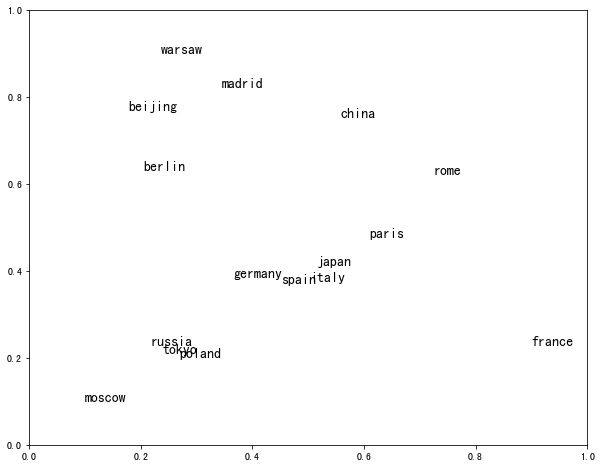

In [23]:
find_nearest_with_vector(skip.T,skip.T['king']-skip.T['male']+skip.T['female'])
words = ['china', 'beijing', 'russia', 'moscow', 'poland', 'warsaw', 'japan', 'tokyo',
        'france', 'paris', 'germany', 'berlin', 'italy', 'rome', 'spain', 'madrid']

plot_words_embedding(skip.T, words)
print(find_nearest_with_vector(skip.T, skip.T['china']+skip.T['capital']))
print(find_nearest_with_vector(skip.T, skip.T['king']-skip.T['male']+skip.T['female']))
print(find_nearest(skip.T, 'china'))
print(find_nearest(glove, '8'))

# Extra

In [24]:
#HW1, HW2
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from utils.hw1 import load_data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

data = load_data("../HW01-BAG-OF-WORDS/train.txt")
X, y = data.text, data.target
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3)

In [25]:
MAX_LENGTH=200
# Yes! it is a good practice to do data processing outside the ML model
wnet = WordNetLemmatizer()

X_train1 = [' '.join([wnet.lemmatize(w) for w in word_tokenize(sent)]) for sent in X_train]
vec = CountVectorizer()
vec.fit_transform(X_train1)
vocab = vec.vocabulary_
vocab['__unknown__'] = len(vocab) + 1
# Numerical encode all the words
unknown = vocab['__unknown__']
X_train2 = [[vocab.get(wnet.lemmatize(w), unknown) for w in word_tokenize(sent)] for sent in X_train]
X_dev2 = [[vocab.get(wnet.lemmatize(w), unknown)for w in word_tokenize(sent)] for sent in X_dev]

# Tensorflow does not handle variable length input well, let's unify all input to the same length
def trim_X(X, max_length=100, default=vocab['__unknown__']):
    for i in range(len(X)):
        if len(X[i]) > max_length:
            X[i] = X[i][:max_length]
        elif len(X[i]) < max_length:
            X[i] = X[i] + [default] * (max_length - len(X[i]))
            
    return np.array(X)
            
X_train2 = trim_X(X_train2, MAX_LENGTH)
X_dev2 = trim_X(X_dev2, MAX_LENGTH)

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, AveragePooling1D, GlobalAveragePooling1D, MaxPooling1D, Dense, GlobalMaxPooling1D, LSTM
from keras.regularizers import l2

model = Sequential()
embedding_layer = Embedding(input_dim=100000,
                            output_dim=100,
                            weights=[glove.T],
                            input_length=MAX_LENGTH,
                            trainable=True)
model.add(embedding_layer)
model.add(Conv1D(filters=400, kernel_size=4, activation="tanh", name="Conv1D-1"))
model.add(GlobalMaxPooling1D(name="MaxPooling1D-1"))
#model.add(LSTM(32))
model.add(Dense(1, activation="sigmoid", name="Dense-1"))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 100)          10000000  
_________________________________________________________________
Conv1D-1 (Conv1D)            (None, 197, 400)          160400    
_________________________________________________________________
MaxPooling1D-1 (GlobalMaxPoo (None, 400)               0         
_________________________________________________________________
Dense-1 (Dense)              (None, 1)                 401       
Total params: 10,160,801
Trainable params: 10,160,801
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model.fit(X_train2, y_train, epochs=20, validation_data=[X_dev2, y_dev])

Train on 7000 samples, validate on 3000 samples
Epoch 1/20
7000/7000 [==============================] - 42s 6ms/step - loss: 0.6732 - acc: 0.5749 - val_loss: 0.6546 - val_acc: 0.5823
Epoch 2/20
7000/7000 [==============================] - 41s 6ms/step - loss: 0.5060 - acc: 0.7839 - val_loss: 0.6044 - val_acc: 0.6807
Epoch 3/20
7000/7000 [==============================] - 42s 6ms/step - loss: 0.3235 - acc: 0.9057 - val_loss: 0.6069 - val_acc: 0.6977
Epoch 4/20
7000/7000 [==============================] - 39s 6ms/step - loss: 0.1588 - acc: 0.9736 - val_loss: 0.6459 - val_acc: 0.7053
Epoch 5/20
7000/7000 [==============================] - 44s 6ms/step - loss: 0.0591 - acc: 0.9971 - val_loss: 0.6949 - val_acc: 0.7137
Epoch 6/20
7000/7000 [==============================] - 44s 6ms/step - loss: 0.0218 - acc: 0.9997 - val_loss: 0.7290 - val_acc: 0.7217
Epoch 7/20
7000/7000 [==============================] - 41s 6ms/step - loss: 0.0107 - acc: 0.9999 - val_loss: 0.7809 - val_acc: 0.7193
Epoch 8

# Final project (Not due this week)

**Work with your teammates and start working on your final project proposal, think about these questions:**
- The problem you try to solve and the value of this problem
- Some current solution to this problem, reference citation if needed
- Outline your approach and the goal you want to achieve
